<a href="https://colab.research.google.com/github/larissamacb/Traffic_Datasets_Analysis/blob/main/NSL_KDD_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and Training Objectives

First of all, we need to understand our data. Naturally, it shows a variety of features (40* attributes) related to a specific cyber attack (or to a normal activity). It is more common, consequently, to use this dataset (NSL-KDD) for two training purposes:

*   To identify if an activity is an attack or not - which leads to better results, given the 67.343 samples classified as "normal" compared to the 58.630 classified as some attack in the train dataset.
*   To identify if it is normal activity or a specific attack category, while also providing the category - a much harder task, since the data are very unbalanced across the categories, but that, in a real scenario, could become valuable information for easier attack containment.

> *Although there are 42 columns, one of them is the attack classification (`label`) and the other is the difficulty to classify that sample correctly (`difficulty`), which, in addition to not being related with the attack itself, can train the model with biased (or "unfair") information.



We can, then, follow the second purpose to make an initial analysis and understand the attacks and their more common features. The attack types encompassed are:

---

### DoS (Denial of Service)
* **Description:** an attack that aims to overload the target, leading it to "deny the service" to other legitimate users, as the name suggests. It compromises the service's availability, either by Volumetric Flood, sending a massive amount of traffic to saturate the target's network bandwidth, or by Connection Flood, sending a huge number of partial or malformed connection requests, forcing the target to allocate resources to "ghost" connections that are never completed, leading to the exhaustion of its state table.
* **Fingerprint:** extremely high, repetead traffic of short duration and with a huge error rate (because the connections are intentionally never completed).
* **Present in the dataset:** `“back”, “land”, “neptune”, “pod”, “smurf”, “teardrop”, “mailbomb”, “apache2”, “processtable”, “udpstorm”.`

---

### Probe
* **Description:** Reconnaissance traffic used to map a network and identify vulnerable targets, for the purpose of information gathering. It includes:
    * **Port/Service Scanning:** systematic sending of packets to a range of ports in one or more hosts to determine which services are active.
    * **Network Scanning:** identification of which hosts are active in a network segment (ex: ICMP scans).
* **Fingerprint:** it is characterized by a "one-to-many" pattern (one attacker for many ports/hosts) or a "many-to-one" pattern (many attackers for a target). The traffic is broad and superficial, with brief connections to multiple distinct services.
* **Present in the dataset:** `“ipsweep”, “nmap”, “portsweep”, “satan”, “mscan”, “saint”.`

---

### R2L (Remote to Local - Remote Access)
* **Description:** Traffic that represents an attempt by an external attacker to obtain unauthorized access (a user account) on a local machine. This is the remote exploitation phase. It includes brute force password attempts (ex: on FTP, SSH), vulnerability exploitation in network services (ex: buffer overflows in a web server) or social engineering.
* **Fingerprint:** It is generally a subtle traffic focused in a single service. It can be identified by multiple failed login attempts, transfer os exploit payloads or anomalous data interactions after connection establishment.
* **Present in thedataset:** `“ftp_write”, “guess_passwd”, “imap”, “multihop”, “phf”, “spy”, “warezclient”, “warezmaster”, “sendmail”, “named”, “snmpgetattack”, “snmpguess”, “xlock”, “xsnoop”, “worm”.`

---

### U2R (User to Root - Privilege Escalation)
* **Description:** Traffic that originates from an attacker who already has access as a common user (local) on the target machine. The goal is to exploit an internal system vulnerability to obtain administrator privileges (root).
* **Fingerprint:** This is the most difficult traffic to detect, because it originates "from inside". It is characterized by a legitimate user executing highly anomalous actions, such as accessing or modifying system configuration files, attempting to execute debugging commands or interacting with the system kernel in non-standard ways.
* **Present in the dataset:** `“buffer_overflow”, “loadmodule”, “perl”, “rootkit”, “httptunnel”, “ps”, “sqlattack”, “xterm”.`

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [4]:
# Formats the floats
pd.set_option('display.float_format', '{:.6f}'.format)

# ----- DataFrames Preparation: column naming and attack categorization -----

# Column Names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Loading the data
df_train_raw = pd.read_csv('KDDTrain+.txt', header=None, names=columns)
df_test_raw = pd.read_csv('KDDTest+.txt', header=None, names=columns)

# Mapping attacks by category
attack_map = {
    'normal': 'normal',
    'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos',
    'mailbomb': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'udpstorm': 'dos',
    'ipsweep': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'satan': 'probe',
    'mscan': 'probe', 'saint': 'probe',
    'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l',
    'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l',
    'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l',
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r'
}

# Replacing the attack name with its category
df_train_raw['attack_type'] = df_train_raw['label'].apply(lambda x: attack_map.get(x, 'unknown'))
df_test_raw['attack_type'] = df_test_raw['label'].apply(lambda x: attack_map.get(x, 'unknown'))

print("\nClasses Distribution (Training):")
print(df_train_raw['attack_type'].value_counts())

print("\nClasses Distribution (Test):")
print(df_test_raw['attack_type'].value_counts())


Classes Distribution (Training):
attack_type
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64

Classes Distribution (Test):
attack_type
normal    9711
dos       7458
r2l       2754
probe     2421
u2r        200
Name: count, dtype: int64


# The Attack Patterns

As we have seen, these attack categories are strongly characterized. Therefore, it could be intuitive to classify the attacks based on their features. For instance, for a DoS attack, we expect a high error rate (`serror_rate` attribute) originating from many incomplete connection attempts, while most of the flags (`flag` attribute) will be S0 by the same reason, implying that a connection was initiated by a SYN, but that the server's SYN-ACK was never acknowledged.

However, with so many attributes and so many numbers, it is not easy for a human being to perform that analysis on such a large number of samples and at the necessary speed. That's why a machine learning model is used to identify these patterns quickly. The point is that, if we already have a notion of what the patterns are, we can make the artificial intelligence's job easier by trying to highlight them to it.
#
----
#
This is where the concept of **Feature Engineering** comes in, which, with this goal, consists of creating new columns in the dataset based on others. We can apply it to NSL-KDD, creating columns that serve as "hints" for the model. In our case, these can be direct hints about the probability of a sample being a DoS, Probe, R2L or U2R attack based on a calculation that demonstrates the influence of the **most important features** for each of them.

We can find these features visually. With a heatmap, we can create a **"threat profile"** for the four types of attacks. This can be done by a comparison of the mean value for an attribute of each attack against the "normal" samples' mean.


# And how do we do that?

First we define what "normal" is. Using the *.fit()* method of StandardScaler only on the data classified ad "normal", we calculate the mean and standard deviation for each feature in the dataset. Afterward, we use the *.transform()* method on the entire the dataset, applying the "ruler" learned from the samples that did not represent attacks. Thus we can understand, for each value, how it compares to the "normal" value. For instance:

* A 0.0 value means "equals to the normal mean".
* A +3.5 value means "3.5 standard deviations above the normal mean".
* A -2.1 value means "2.1 standard deviations below the normal mean".

Finally, to create the heatmap, we summarize the data by calculating the mean for each attribute by attack type. Thus, the number in each cell of the heatmap will be the mean of all the Z-Scores (by how many standard deviations a data point is from the mean of a data set) of that feature for that type of attack.


### About the colors

From the image (a little below), we can get a sense of each feature's relevance based on its color.

* **White (Z-Score ~0):** this indicates a given attack's value for the feature does not differ much from the normal traffic.
* **Red (Positive Z-Score):** this means that, on average, the attack has values highly above normal for that feature.
* **Blue (Negative Z-Score):** this indicates that, on average, the attack has values highly below normal.

# Exploratory Data Analysis (EDA)

Note that here we joined the train and test data to perform the analysis, but in the training phase, the test data will not be used.

In [5]:
# ----- Demonstration of attack characterization using heatmaps -----

# The first step is to separate the features that will be used in each heatmap

df_combined_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

categorical_cols = ['protocol_type', 'service', 'flag']
df_combined_processed = pd.get_dummies(df_combined_raw, columns=categorical_cols)

all_feature_names = df_combined_processed.drop(columns=['label', 'difficulty', 'attack_type']).columns.tolist()

original_numerical_cols = df_train_raw.select_dtypes(include=[np.number]).columns.tolist()
original_numerical_cols.remove('difficulty')

# Separation of categorical columns (which originate dummies) for analysis in separate charts
cols_protocol = [col for col in all_feature_names if col.startswith('protocol_type_')]
cols_service = [col for col in all_feature_names if col.startswith('service_')]
cols_flag = [col for col in all_feature_names if col.startswith('flag_')]

# Identification of binary features (0 or 1) that are not dummies
original_binary_flag_cols = [
    'land', 'logged_in', 'root_shell', 'su_attempted',
    'is_host_login', 'is_guest_login'
    ]

# Pure quantitative (excluding binary ones)
original_quantitative_cols = [col for col in original_numerical_cols if col not in original_binary_flag_cols]

print(f"Total of {len(all_feature_names)} features identified (including dummies).")
print(f"Quantitative Numerical: {len(original_quantitative_cols)}")
print(f"Binary Numerical: {len(original_binary_flag_cols)}")
print(f"Protocol Dummies: {len(cols_protocol)}")
print(f"Service Dummies: {len(cols_service)}")
print(f"Flag Dummies: {len(cols_flag)}")

Total of 122 features identified (including dummies).
Quantitative Numerical: 32
Binary Numerical: 6
Protocol Dummies: 3
Service Dummies: 70
Flag Dummies: 11


In [6]:
# Here we compare the attack samples in relation to the normal samples

df_combined_normal_only = df_combined_processed[df_combined_processed['attack_type'] == 'normal']

# Scaling based on "normal"
scaler_combined = StandardScaler()
scaler_combined.fit(df_combined_normal_only[original_quantitative_cols]) # Train only on the quantitative features

# Transform only the pure quantitative features
scaled_combined_quant_data = scaler_combined.transform(df_combined_processed[original_quantitative_cols])
df_combined_scaled_quant = pd.DataFrame(scaled_combined_quant_data, columns=original_quantitative_cols)

# Get the qualitative features (binary + dummies) WITHOUT scaling
qualitative_cols_all = original_binary_flag_cols + cols_protocol + cols_service + cols_flag
df_combined_qual = df_combined_processed[qualitative_cols_all].reset_index(drop=True)

# Join the two groups
df_combined_scaled_correct = pd.concat([df_combined_scaled_quant, df_combined_qual], axis=1)
df_combined_scaled_correct['attack_type'] = df_combined_processed['attack_type'].values

heatmap_data_full = df_combined_scaled_correct.groupby('attack_type').mean()

heatmap_data_attacks_only = heatmap_data_full.drop('normal')

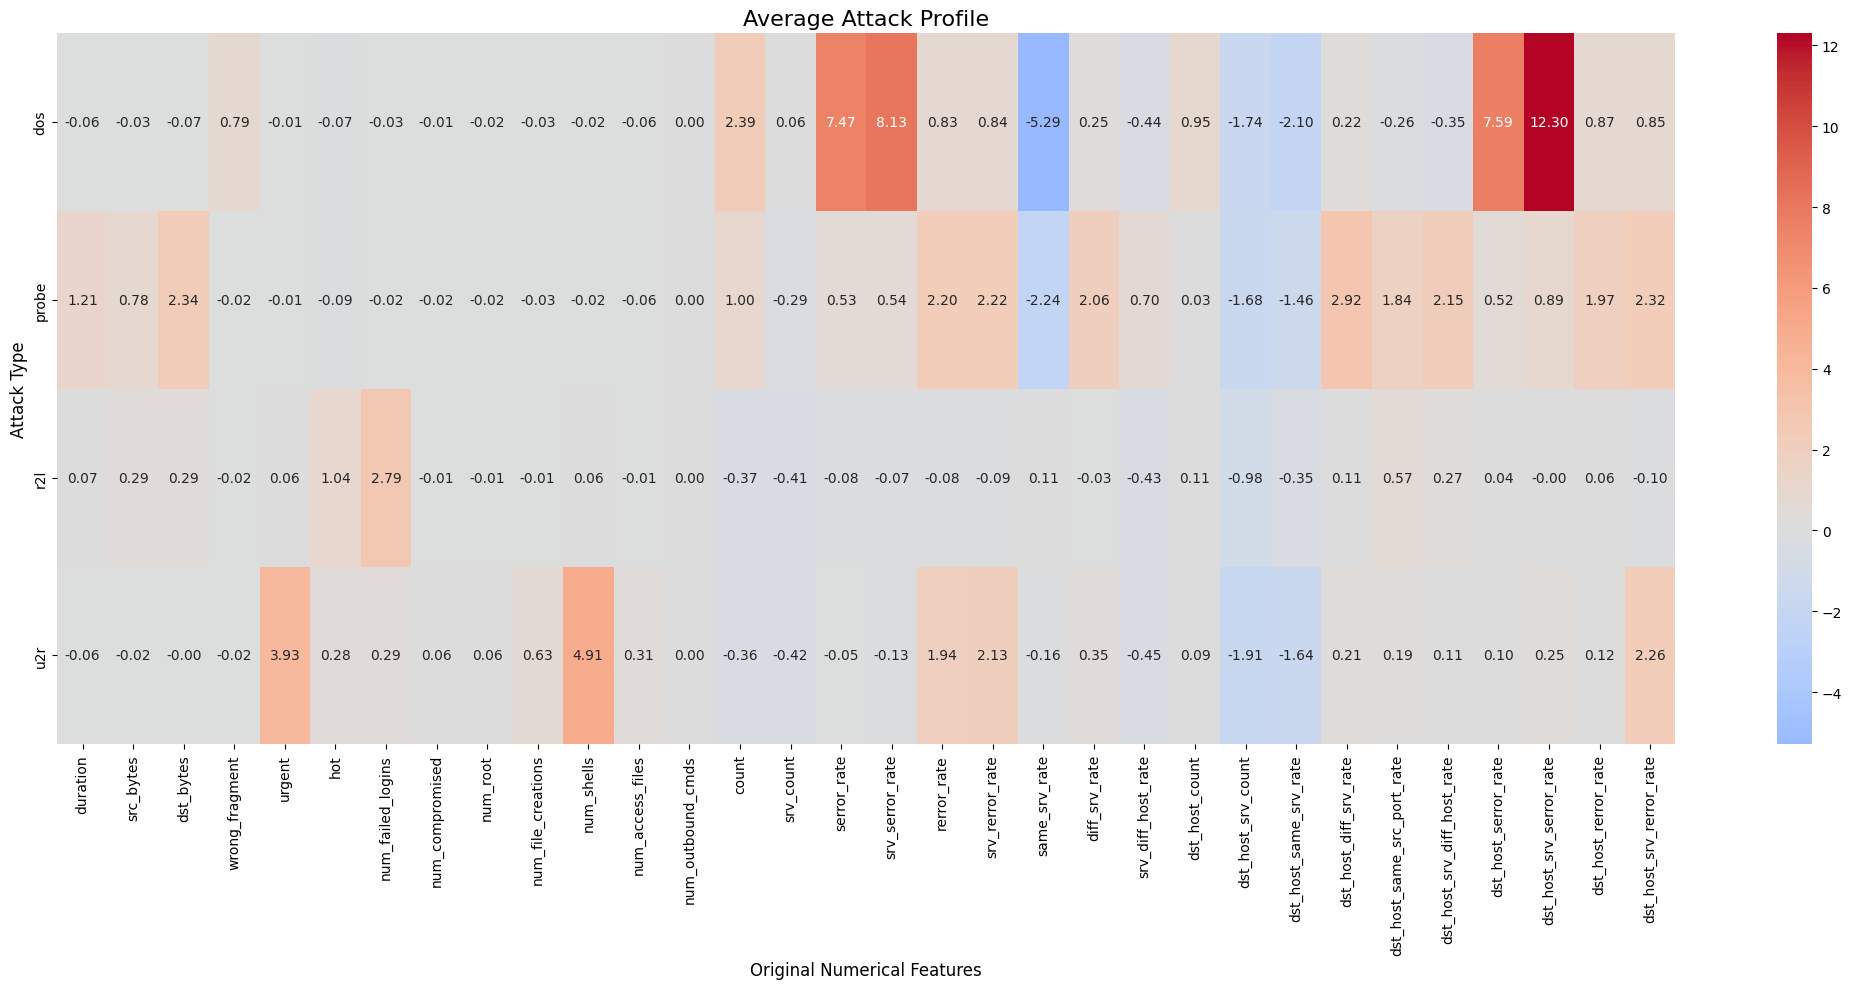

In [7]:
# ----- Heatmap 1: Quantitative Features -----

plt.figure(figsize=(21, 10))
sns.heatmap(
    heatmap_data_attacks_only[original_quantitative_cols], # Filters for quantitative features
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Average Attack Profile', fontsize=16)
plt.xlabel('Original Numerical Features', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

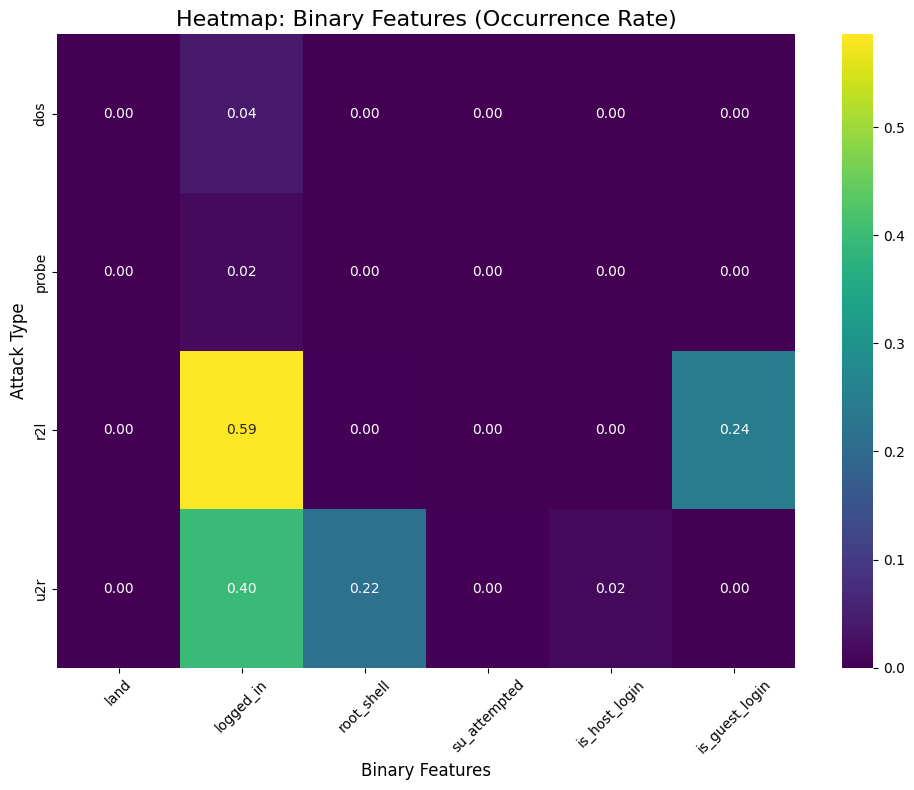

In [8]:
# --- Heatmap 2: Binary Features ---

# This is based only on occurrence rate, not on comparison to normal
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_attacks_only[original_binary_flag_cols], # Filters for binary features
    annot=True,
    fmt='.2f',      # Show as float
    cmap='viridis', # We use a 'viridis' cmap (0 -> 1) instead of 'coolwarm' (divergent)
    center=None     # There is no 'center' here, the scale is from 0 to 1
)
plt.title('Heatmap: Binary Features (Occurrence Rate)', fontsize=16)
plt.xlabel('Binary Features', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

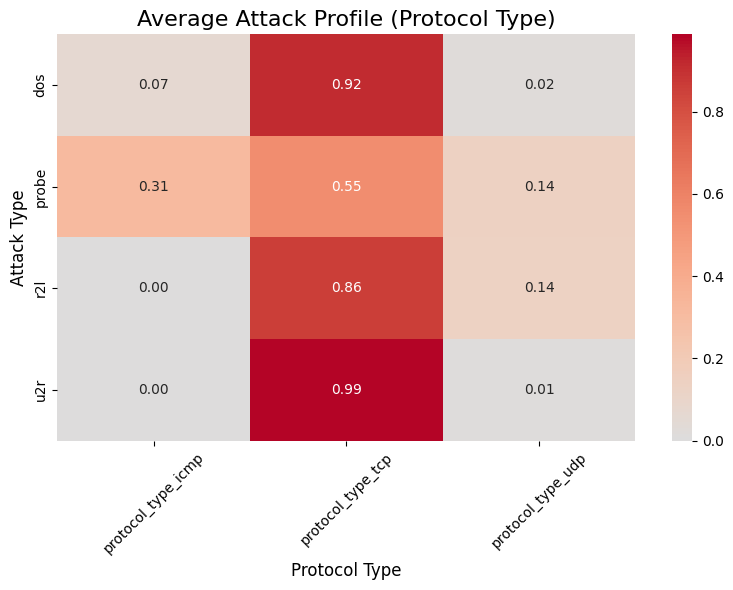

In [9]:
# --- Heatmap 3: Protocol Type ---

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_attacks_only[cols_protocol], # Filters for protocol dummies
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Average Attack Profile (Protocol Type)', fontsize=16)
plt.xlabel('Protocol Type', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

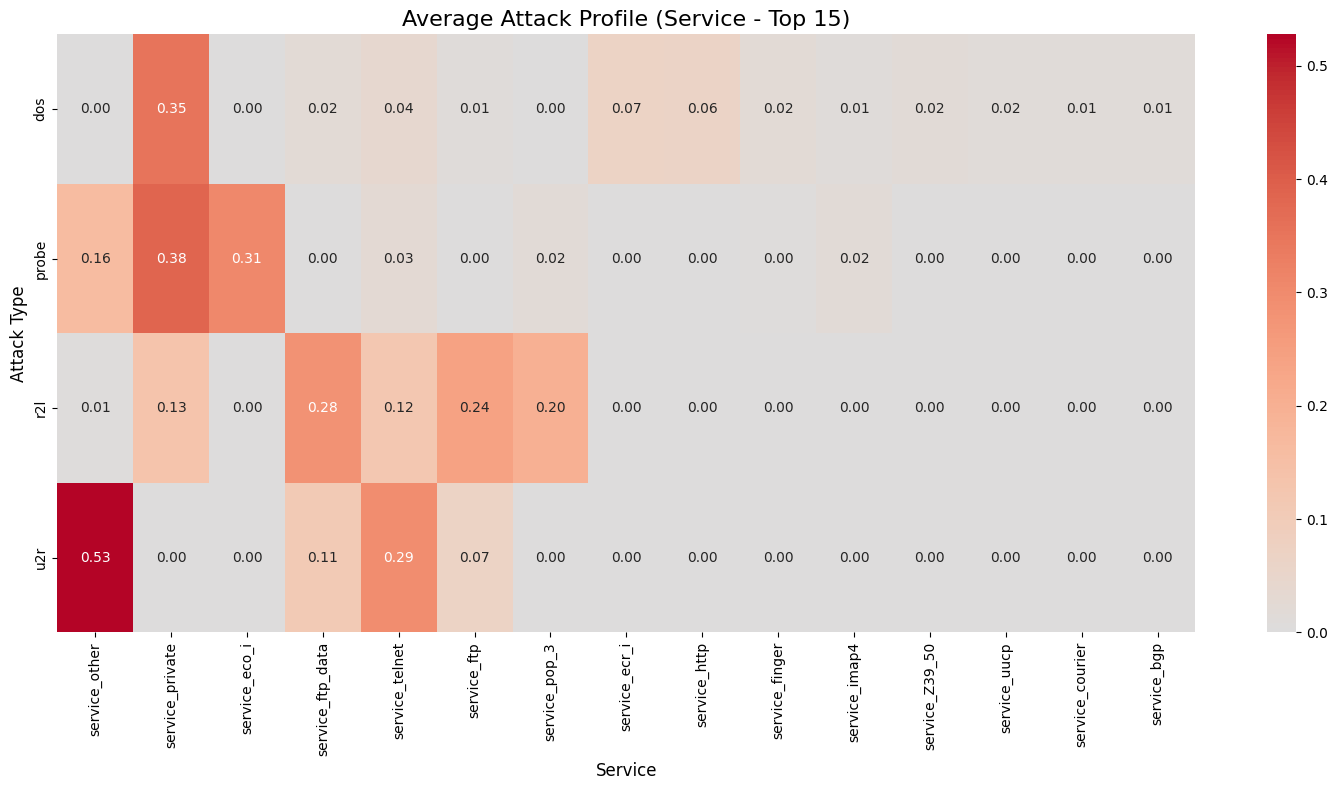

In [10]:
# --- Heatmap 4: Service (Top 15 by Variance) ---

service_variance = heatmap_data_attacks_only[cols_service].var(axis=0)
top_15_services = service_variance.sort_values(ascending=False).head(15).index.tolist()
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_data_attacks_only[top_15_services], # Filters for the Top 15 services
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Average Attack Profile (Service - Top 15)', fontsize=16)
plt.xlabel('Service', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

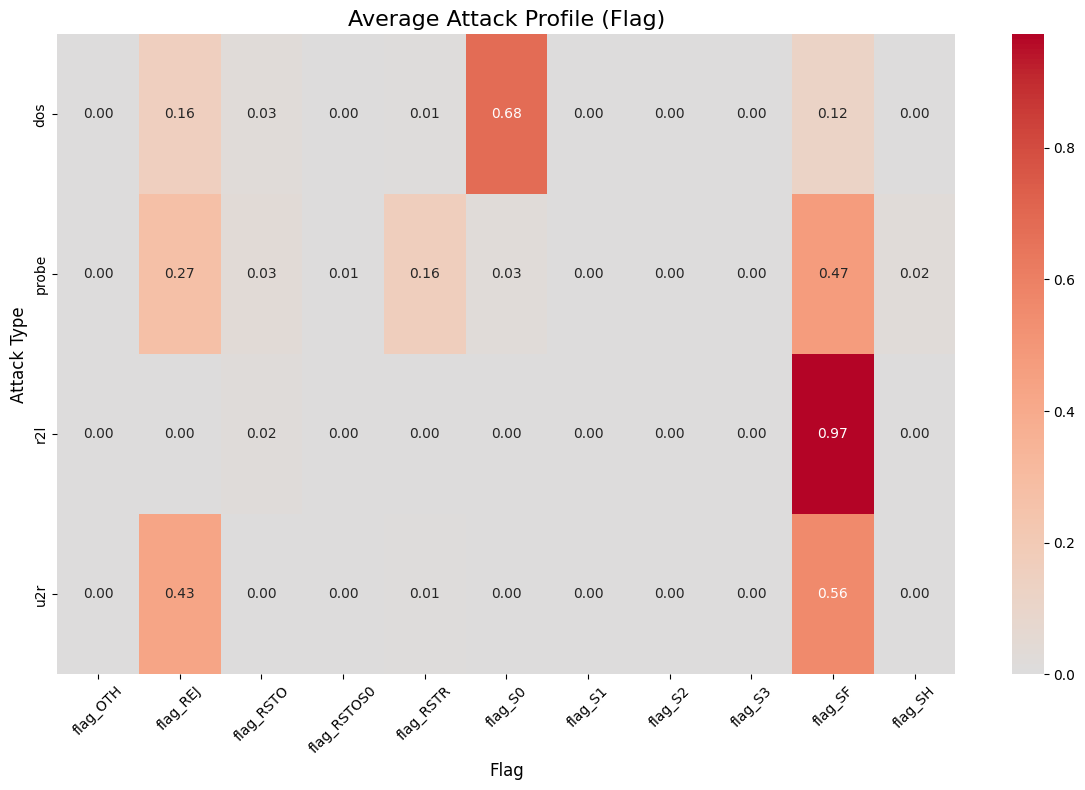

In [11]:
# --- Heatmap 5: Flag Dummies ---

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_attacks_only[cols_flag], # Filters for flag dummies
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Average Attack Profile (Flag)', fontsize=16)
plt.xlabel('Flag', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model Training

In [12]:
# ----- Data Preprocessing: One-Hot Encoding -----

# We join train and test to ensure OHE creates the same columns for both datasets
combined_df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)
categorical_cols = ['protocol_type', 'service', 'flag']

print(f"Shape before One-Hot Encoding: {combined_df.shape}")

# Applying get_dummies to the categorical columns
combined_df_processed = pd.get_dummies(combined_df, columns=categorical_cols)

print(f"Shape after One-Hot Encoding: {combined_df_processed.shape}")

Shape before One-Hot Encoding: (148517, 44)
Shape after One-Hot Encoding: (148517, 125)


In [13]:
# ----- Separation of Train and Test DataFrames and x and y

train_processed = combined_df_processed.iloc[:len(df_train_raw)]
test_processed = combined_df_processed.iloc[:len(df_test_raw)]

# Columns to drop
labels_to_drop = ['label', 'difficulty', 'attack_type']

# Saving the labels we created
y_train = train_processed['attack_type']
y_test = test_processed['attack_type']

# Creating the DataFrames with features only
X_train_numeric = train_processed.drop(columns=labels_to_drop)
X_test_numeric = test_processed.drop(columns=labels_to_drop)

# Saving the list of final feature names for later identification
feature_names = X_train_numeric.columns.tolist()

print(f"X_train Shape: {X_train_numeric.shape} | y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test_numeric.shape} | y_test Shape: {y_test.shape}")

X_train Shape: (125973, 122) | y_train Shape: (125973,)
X_test Shape: (22544, 122) | y_test Shape: (22544,)


In [14]:
# ----- Data Preprocessing: StandardScaler -----

scaler = StandardScaler()

# Separation of samples categorized as normal
train_normal_only = X_train_numeric[y_train == 'normal']

# Training the scaler only with the normal samples, as they will be our baseline
# for comparison with the other samples
scaler.fit(train_normal_only)

# Applying the scaler to all data (train and test)
# This way, the numbers will be a comparison to "normal"
X_train_scaled_data = scaler.transform(X_train_numeric)
X_test_scaled_data = scaler.transform(X_test_numeric)

# Reconstructing the DataFrames with the column names
X_train_scaled = pd.DataFrame(X_train_scaled_data, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled_data, columns=feature_names)

X_train_scaled.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.129241,-0.030237,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
1,-0.129241,-0.031062,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
2,-0.129241,-0.031411,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,13.756252,-0.073413,-0.042074,-0.025859,-4.006103,-0.005450
3,-0.129241,-0.030856,0.058405,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
4,-0.129241,-0.030935,-0.059724,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450


# Using the Heatmap Weights

Below we are creating the heatmap only with the train data, but the process is the same.

Using the results of this heatmap, we can select a number of features with the highest relevance to characterize each attack and create the attributes that will help our model make predictions: `dos_risk_score`, `probe_risk_score`, `r2l_risk_score` and `u2r_risk_score`, which will contain a value that is higher or lower depending on the probability of the sample being classified as one of these attacks. Based on my tests, the number of feature that showed the best results was 7, so we will consider this number and check which features we obtained with this analysis:

In [15]:
# ----- Generating weights for the heatmap (For the Scores) -----

temp_heatmap_df = X_train_scaled.copy()
temp_heatmap_df['attack_type'] = y_train.values # Temporarily add labels
heatmap_weights = temp_heatmap_df.groupby('attack_type').mean() # Calculates the mean for each column for all attack_type
# Note: in the line above, 'attack_type' becomes the index in heatmap_weights due to the groupby

# Selection of the most important features
attack_heatmap_data = heatmap_weights.drop('normal') # Here the focus is on the attacks
attack_heatmap_abs = attack_heatmap_data.abs() # So that positive and negative values are considered equally
top_features_weights = {} # We will store in this dictionary, for each attack, the features with the highest weight and their weight
N_TOP_FEATURES = 7

# Remember that we are not dealing with multiple samples here, just the mean for each column for each attack
for attack_type, abs_row_data in attack_heatmap_abs.iterrows(): # iterrows gets (index, row data)
    # Sorts the row data from the highest to the lowest value, gets only the amount in N_TOP_FEATURES
    # and stores their indexes, which are the column names
    top_features_names = abs_row_data.sort_values(ascending=False).head(N_TOP_FEATURES).index
    # Fetches the original values (with correct positive and negative signs), creating a series with index and value
    original_values = heatmap_weights.loc[attack_type, top_features_names]
    # Adds a list of tuples to our dictionary of attacks, features, and weights
    top_features_weights[attack_type] = list(original_values.items())

    print(f"\nTop {N_TOP_FEATURES} features chosen for '{attack_type}_risk_score':")
    for feature, weight in top_features_weights[attack_type]:
        print(f"   - {feature} (Weight/Z-Score: {weight:.4f})")


Top 7 features chosen for 'dos_risk_score':
   - dst_host_srv_serror_rate (Weight/Z-Score: 13.0162)
   - flag_S0 (Weight/Z-Score: 10.2685)
   - srv_serror_rate (Weight/Z-Score: 8.4998)
   - dst_host_serror_rate (Weight/Z-Score: 7.9777)
   - serror_rate (Weight/Z-Score: 7.8022)
   - same_srv_rate (Weight/Z-Score: -5.3853)
   - flag_SF (Weight/Z-Score: -3.5799)

Top 7 features chosen for 'probe_risk_score':
   - flag_SH (Weight/Z-Score: 4.1665)
   - service_eco_i (Weight/Z-Score: 4.0125)
   - flag_RSTR (Weight/Z-Score: 3.9745)
   - service_private (Weight/Z-Score: 3.3853)
   - dst_host_diff_srv_rate (Weight/Z-Score: 2.8097)
   - dst_bytes (Weight/Z-Score: 2.7000)
   - protocol_type_icmp (Weight/Z-Score: 2.4288)

Top 7 features chosen for 'r2l_risk_score':
   - hot (Weight/Z-Score: 3.5108)
   - is_guest_login (Weight/Z-Score: 2.6664)
   - service_ftp (Weight/Z-Score: 2.5866)
   - service_ftp_data (Weight/Z-Score: 2.0361)
   - dst_host_same_src_port_rate (Weight/Z-Score: 1.8680)
   - serv

# Risk Score Calculation

Let's understand the Risk Score calculation using a Z sample as an example. For this sample, we will calculate its dos_risk_score.
First, we separate from it the 7 features with the highest relevance identified by the heatmap and obtain their values:

* `dst_host_srv_serror_rate` = 17.521678
* `flag_S0` = 13.756252
* `srv_serror_rate` = 11.430875
* `dst_host_serror_rate` = 10.717485
* `serror_rate` = 10.471827
* `same_srv_rate` = -6.368096
* `flag_SF` = -4.006103

> Note that we created dummy variables for the categorical features, so features such as `flag` were split into "`flag_S0`', "`flag_S1`", "`flag_S2`", etc.

Then, we multiply each value by its respective weight found in the heatmap. Example:
* `dst_host_srv_serror_rate` of sample Z × weight of `dst_host_srv_serror_rate` (on heatmap)
* 17.521678 x 13.0162 = 228.0656651836

We do the same for the others:
* `flag_S0` = 13.756252 x 10.2685 = 141.256073662
* `srv_serror_rate` = 11.430875 x 8.4998 = 97.160151325
* `dst_host_serror_rate` = 10.717485 x 7.9777 = 85.5008800845
* `serror_rate` = 10.471827 x 7.8022 = 81.7032886194
* `same_srv_rate` = -6.368096 x -5.3853 = 34.2941073888
* `flag_SF` = -4.006103 x -3.5799 = 14.3414481297

In the end, we sum up all the results:
> 228.0656651836 + 141.256073662 + 97.160151325 + 85.5008800845 + 81.7032886194 + 34.2941073888 + 14.3414481297 = 682.321614393

The `dos_risk_score` for the Z sample is equal to 682.321614393. An extremely high value, which should indicate to the model that this sample corresponds to a DoS attack, especially if the other scores are relatively low. To calculate them, the same process can be done, but for their respective most relevant features.


In [16]:
# ----- Applying the weights to create the final dataset (with the scores) -----

final_X_train = X_train_scaled.copy()
final_X_test = X_test_scaled.copy()

for attack_type, weights_list in top_features_weights.items():
    score_col_name = f"{attack_type}_risk_score" # Defines the name of the column we are creating
    final_X_train[score_col_name] = 0.0 # Initializes the cell value
    final_X_test[score_col_name] = 0.0
    for feature, weight in weights_list:
        final_X_train[score_col_name] += final_X_train[feature] * weight # Calculates the score for that sample
        final_X_test[score_col_name] += final_X_test[feature] * weight

# The new features created can be viewed at the end
final_X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,dos_risk_score,probe_risk_score,r2l_risk_score,u2r_risk_score
0,-0.129241,-0.030237,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,-7.695909,-1.707827,9.434563,3.798372
1,-0.129241,-0.031062,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,26.622027,10.752759,7.284368,9.202769
2,-0.129241,-0.031411,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,13.756252,-0.073413,-0.042074,-0.025859,-4.006103,-0.005450,682.321224,26.970057,0.391147,2.604205
3,-0.129241,-0.030856,0.058405,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,33.432998,-2.027382,-3.336299,-4.304683
4,-0.129241,-0.030935,-0.059724,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,-7.695909,-2.346325,-3.556603,-4.511707


Class Distribution after Undersampling:
Counter({'dos': 52, 'normal': 52, 'probe': 52, 'r2l': 52, 'u2r': 52})

----- Result with Undersampler + RandomForest -----
------------------------------------------------------------------
              precision    recall  f1-score   support

         dos       0.99      0.97      0.98      8271
      normal       0.98      0.91      0.95     12042
       probe       0.86      0.97      0.91      2037
         r2l       0.26      0.93      0.40       183
         u2r       0.03      1.00      0.06        11

    accuracy                           0.94     22544
   macro avg       0.63      0.96      0.66     22544
weighted avg       0.97      0.94      0.95     22544



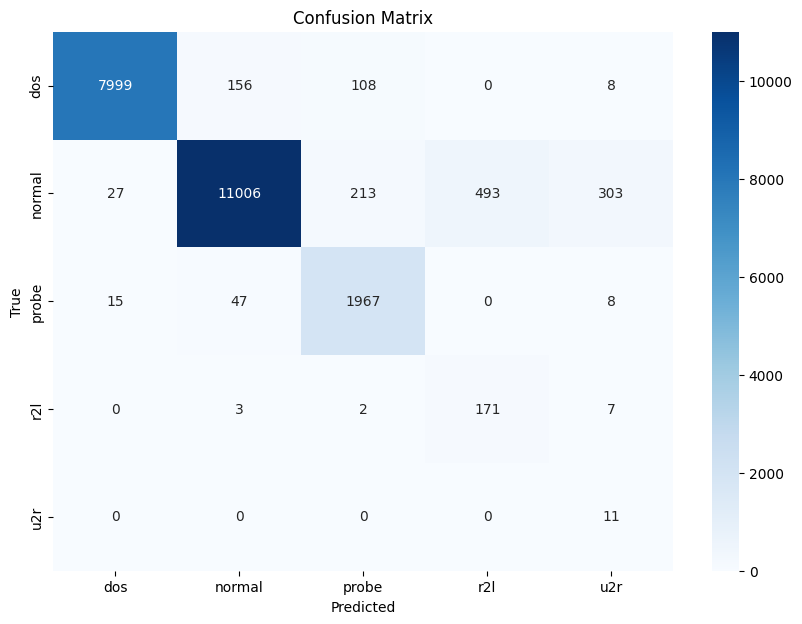

In [17]:
# ----- Training with Undersampling + RandomForest -----

# 'auto' = reduces everything except the minority class.
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')

# Applying the Undersampler
X_train_sampled, y_train_sampled = rus.fit_resample(final_X_train, y_train)

print("Class Distribution after Undersampling:")
print(Counter(y_train_sampled))

# Training the RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train_sampled, y_train_sampled)

# Predictions on the test set
y_pred_test = model.predict(final_X_test)

print("\n----- Result with Undersampler + RandomForest -----")
print("-" * 66)
print(classification_report(y_test, y_pred_test, zero_division=0))

labels_order = model.classes_
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels_order)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=labels_order, yticklabels=labels_order, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Looking at the results of Undersampling + RandomForest

Considering that the model we are aiming to train could be integrated into a SIEM (Security Information and Event Management), we want it to be able to identify as many attacks as possible. This way, security professionals can detect them and handle them quickly. To verify if our model is doing this, we look at **recall**.

> **Recall** is a metric that measures the ability of a model to find all the relevant instances, answering the question: "Of all the actual positive cases, how many did the model correctly identify?"

However, it's also important that it identifies attacks *correctly*, because it wouldn't be ideal if alerts were constantly popping up that needed investigation. To ensure this, we look at **precision**.

> **Precision** is a metric that measures the accuracy of a model's positive predictions, calculated as the ratio of true positives to all positive predictions (true positives plus false positives). It answers the question: "Of all the instances the model predicted as positive, how many were actually correct?"

The model above had great recall. It even managed to correctly identify all U2R attacks! On the other hand, it falsely classified hundreds of connections as U2R when they were, in fact, just normal traffic.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4336
[LightGBM] [Info] Number of data points in the train set: 125973, number of used features: 114
[LightGBM] [Info] Start training from score -1.009014
[LightGBM] [Info] Start training from score -0.626269
[LightGBM] [Info] Start training from score -2.380247
[LightGBM] [Info] Start training from score -4.841080
[LightGBM] [Info] Start training from score -7.792579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

----- Result with LGBM -----
------------------------------------------------------------------
              precision    recall  f1-score   support

         dos       0.99      0.99      0.99      8271
      normal       0.99      0.99      0.99     12042
       probe       0.98      0.99      0

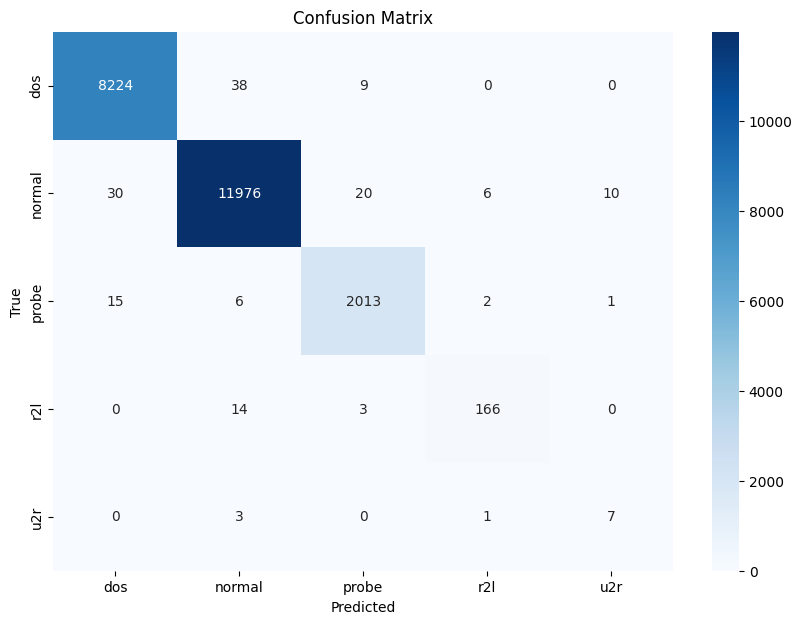

In [18]:
# ----- Training with LGBM (no Undersampling) -----

# is_unbalance=True tells LGBM to "pay more attention" to minority classes during training.
model_lgbm = lgb.LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1)

# Training
model_lgbm.fit(final_X_train, y_train)

# Predictions
y_pred_lgbm = model_lgbm.predict(final_X_test)

print("\n----- Result with LGBM -----")
print("-" * 66)
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

labels_order = model_lgbm.classes_
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm, labels=labels_order)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_lgbm, annot=True, fmt='d', xticklabels=labels_order, yticklabels=labels_order, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Now, the results of LGBM

After some tests, training the model with LGBM (without undersampling) yielded the best results. Precision and recall were significantly lower for U2R compared to the other attacks, but this was expected given such an unbalanced dataset, and it remains a very good result compared to other tests. It is also noteworthy the good result for R2L, which also had less data available but ended up performing very well in this test.

# Evaluating the Impact of our Feature Engineering

Below, we have an analysis of which features our best-performing model (LGBM) considered the most relevant. Looking specifically at the ones we created, we have:

*   `probe_risk_score` in **4th** place
*   `r2l_risk_score` in **5th** place
*   `u2r_risk_score` in **7th** place
*   `dos_risk_score` in **11th** place

This demonstrates how significantly the features we created influenced the good result achieved.


/tmp/ipython-input-3108631520.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


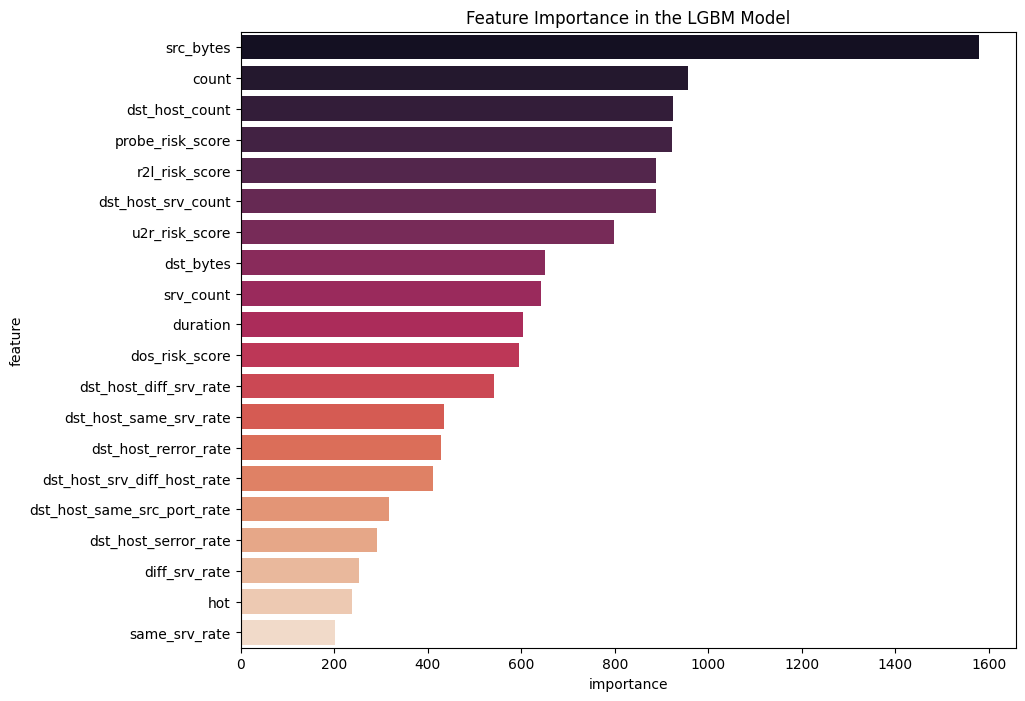

                feature  importance
1             src_bytes        1578
19                count         957
28       dst_host_count         924
123    probe_risk_score         922
124      r2l_risk_score         888
29   dst_host_srv_count         887
125      u2r_risk_score         798
2             dst_bytes         650
20            srv_count         642
0              duration         603


In [19]:
# ----- Feature Importance Check -----

feature_importance_df = pd.DataFrame({
    'feature': final_X_train.columns,
    'importance': model_lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plot the 20 most important features
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20),
    palette='rocket'
)
plt.title('Feature Importance in the LGBM Model')
plt.show()

print(feature_importance_df.head(10))

# Conclusion

This study was an attempt to find the best "simple" solution for classifying the NSL-KDD dataset, as well as to provide an overview of the characteristics of four well-known types of cyber attacks. It is important to note that NSL-KDD is an outdated dataset, and many things have evolved since then. Therefore, to get a more modern view of attacks, it is important to examine more recent datasets that serve the same purpose.

There may be more effective ways to improve the classification performed here (through machine learning), such as Hierarchical Classification. However, in terms of efficiency, it might not be the ideal way to solve this problem. If you have tested anything else that led to better results, I would love to know!